In [1]:
# !pip install protobuf==3.20.1

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import os
from torchvision.io import read_image
import torchvision.transforms as T
from pathlib import Path
import tqdm

from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

from PIL import Image

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(12, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    #plot
    plt.show()
        


def filter_model_output(output,score_threshold):
  filtred_output = list()
  for image in output:
    filtred_image = dict()
    for key in image.keys():
      filtred_image[key] = image[key][image['scores'] >= score_threshold]
    filtred_output.append(filtred_image)
  return filtred_output

def get_boolean_mask(output):
  for index,pred in enumerate(output):
    output[index]['masks'] = pred['masks'] > 0.5
    output[index]['masks'] = output[index]['masks'].squeeze(1)
  return output

def list_file_jpg(directory):
    return [f for f in os.listdir(directory) if f.endswith('.jpg')]
  
def list_file_png(directory):
    return [f for f in os.listdir(directory) if f.endswith('.png')]

def extract_number(path):
    number = path.split('.')[0]  # Remove the extension
    number = number[2:]  # Remove the 'in' prefix
    return number
  

def calculate_precision_recall(tensor_true, tensor_pred):
    # Convert tensors to numpy arrays
    true_np = tensor_true.cpu().numpy().flatten()
    pred_np = tensor_pred.cpu().numpy().flatten()

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = ((true_np != 0) & (pred_np != 0)).sum()
    FP = ((true_np == 0) & (pred_np != 0)).sum()
    FN = ((true_np != 0) & (pred_np == 0)).sum()

    # Calculate Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall
  
def calculate_iou(gt, pred, threshold=0.5):
    gt = gt>0.1
    pred = pred>threshold
    intersection = torch.logical_and(gt, pred).sum().item()
    union = torch.logical_or(gt, pred).sum().item()
    iou = intersection / union if union > 0 else 0
    return iou

In [3]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval().to(device)
batch_size = 8
transform = weights.transforms()

cuda


In [4]:
model_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

def filter_output(output, class_names:list):
  filtred_output = list()
  for image in output:
    filtred_image = dict()
    for key in image.keys():
      for object_class in class_names:
        idx = model_class_names.index(object_class)
        filtred_image[key] = image[key][image['labels'] == idx]
    filtred_output.append(filtred_image)
  return filtred_output


# Select 50 images at random for each class to run grid search

In [5]:
def inference(score_threshold, class_name, images_number, folder):
    output_tensor_list = []
    #select the images containing the number
    images_path = [f'baseline/{folder}/input/in{number}.jpg' for number in images_number]
    images = [read_image(image_path) for image_path in images_path]
    images = [transform(image) for image in images]
    images = [image.to(device) for image in images]
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        with torch.no_grad():
            outputs = model(batch)
        # outputs = filter_model_output(outputs, score_threshold)
        if class_name != None:
            outputs = filter_output(outputs, class_name)
        for j,output in enumerate(outputs):
            try:
                mask = torch.max(output['masks'], axis=0).values.squeeze(0)
            except:
                mask = torch.zeros_like(images[j][0])
            output_tensor_list.append(mask)
    return output_tensor_list

In [19]:
import random


ious_highway, ious_office, ious_pedestrians, ious_PETS2006 = [], [], [], []

for folder in ['highway','office', 'pedestrians', 'PETS2006']:
    # Path to the folder containing the images
    folder_path = f"baseline\{folder}\input"

    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter out non-image files (optional)
    image_files = [file for file in files if file.endswith((".jpg", ".jpeg", ".png"))]

    # Choose 50 images at random
    random_images = random.sample(image_files, 50)
    random_images_number = [extract_number(image) for image in random_images]
    for score_threshold in [0.5, 0.8, 0.95]:
        if folder == 'highway':
            output_tensor_list = inference(score_threshold, None, random_images_number, folder)
        else:
            output_tensor_list = inference(score_threshold, ['person', 'bicycle'], random_images_number, folder)
        ground_truth_paths = list_file_png(f'baseline/{folder}/groundtruth')
        # select the ground truth containing the number
        ground_truth_paths = [f'baseline/{folder}/groundtruth/gt{number}.png' for number in random_images_number]
        ground_truth_images = [Image.open(ground_truth_path).convert('L') for ground_truth_path in ground_truth_paths]
        ground_truth_images_tensor = [F.to_tensor(ground_truth_image).to(device) for ground_truth_image in ground_truth_images]
        for mask_threshold in [0.1, 0.5, 0.9]:
            iou = 0
            for i in range(len(output_tensor_list)):
                iou += calculate_iou(ground_truth_images_tensor[i], output_tensor_list[i], mask_threshold)
            if folder == 'highway':
                ious_highway.append(iou / len(output_tensor_list))
            elif folder == 'office':
                ious_office.append(iou / len(output_tensor_list))
            elif folder == 'pedestrians':
                ious_pedestrians.append(iou / len(output_tensor_list))
            else:
                ious_PETS2006.append(iou / len(output_tensor_list))
            print(f'iou_{folder}_{score_threshold}_{mask_threshold}: {iou / len(output_tensor_list):.3f}')
            
            
        

iou_highway_0.5_0.1: 0.806
iou_highway_0.5_0.5: 0.739
iou_highway_0.5_0.9: 0.585
iou_highway_0.8_0.1: 0.760
iou_highway_0.8_0.5: 0.692
iou_highway_0.8_0.9: 0.547
iou_highway_0.95_0.1: 0.532
iou_highway_0.95_0.5: 0.480
iou_highway_0.95_0.9: 0.379
iou_office_0.5_0.1: 0.669
iou_office_0.5_0.5: 0.727
iou_office_0.5_0.9: 0.583
iou_office_0.8_0.1: 0.791
iou_office_0.8_0.5: 0.843
iou_office_0.8_0.9: 0.648
iou_office_0.95_0.1: 0.789
iou_office_0.95_0.5: 0.841
iou_office_0.95_0.9: 0.648
iou_pedestrians_0.5_0.1: 0.451
iou_pedestrians_0.5_0.5: 0.409
iou_pedestrians_0.5_0.9: 0.263
iou_pedestrians_0.8_0.1: 0.488
iou_pedestrians_0.8_0.5: 0.436
iou_pedestrians_0.8_0.9: 0.270
iou_pedestrians_0.95_0.1: 0.482
iou_pedestrians_0.95_0.5: 0.429
iou_pedestrians_0.95_0.9: 0.261
iou_PETS2006_0.5_0.1: 0.699
iou_PETS2006_0.5_0.5: 0.697
iou_PETS2006_0.5_0.9: 0.493
iou_PETS2006_0.8_0.1: 0.695
iou_PETS2006_0.8_0.5: 0.689
iou_PETS2006_0.8_0.9: 0.485
iou_PETS2006_0.95_0.1: 0.653
iou_PETS2006_0.95_0.5: 0.647
iou_PETS2

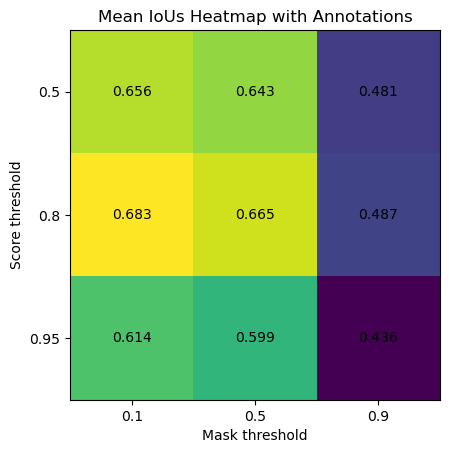

In [27]:
#convert the list to numpy array
ious_highway = np.array(ious_highway)
ious_office = np.array(ious_office)
ious_pedestrians = np.array(ious_pedestrians)
ious_PETS2006 = np.array(ious_PETS2006)

ious_tot = (ious_highway + ious_office + ious_pedestrians + ious_PETS2006)/4
#reshape to a 3x3 matrix
data = ious_tot.reshape(3,3)
# Create a heatmap
plt.imshow(data, cmap='viridis', interpolation='nearest')

# Annotate the heatmap with the values
for i in range(len(data)):
    for j in range(len(data[0])):
        plt.text(j, i, "{:.3f}".format(data[i, j]), ha='center', va='center', color='black')

# Customize the x and y axis
plt.xticks(ticks=np.arange(len(data[0])), labels=['0.1', '0.5', '0.9'])
plt.yticks(ticks=np.arange(len(data)), labels=['0.5', '0.8', '0.95'])
plt.xlabel('Mask threshold')
plt.ylabel('Score threshold')
plt.title('Mean IoUs Heatmap with Annotations')
# Show the plot
plt.show()


In [6]:
folder = 'office'
class_names = ['person']


output_dir = f'baseline/{folder}/prediction_blurred'
# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

list_images_path = list_file_jpg(f'baseline/{folder}/input_blurred')

for i in range(0, len(list_images_path), batch_size):
    # print(i)
    batch_images_path = list_images_path[i:i+batch_size]
    number_list = [extract_number(path) for path in batch_images_path]
    batch_images = [read_image(f'baseline/{folder}/input/' + img_path) for img_path in batch_images_path]
    batch_images = [transform(img).to(device) for img in batch_images]
    with torch.no_grad():
        output = model(batch_images)
        output = filter_output(output, class_names)
    outputs = filter_model_output(output, 0.95)
    for j,output in enumerate(outputs):
        try:
            mask = torch.max(output['masks'], axis=0).values.squeeze(0)
            mask = mask.detach().cpu().numpy()
        except:
            mask = np.zeros((240, 320)) 
        #save the image to the output directory
        plt.imsave(os.path.join(output_dir, 'mask' + extract_number(number_list[j])+'.jpg'), mask, cmap='gray')
    

In [6]:
for folder in ['pedestrians', 'PETS2006']:
    class_names = ['person', 'bicycle']


    output_dir = f'baseline/{folder}/prediction_blurred'
    # Create the directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    list_images_path = list_file_jpg(f'baseline/{folder}/input_blurred')

    for i in range(0, len(list_images_path), batch_size):
        # print(i)
        batch_images_path = list_images_path[i:i+batch_size]
        number_list = [extract_number(path) for path in batch_images_path]
        batch_images = [read_image(f'baseline/{folder}/input/' + img_path) for img_path in batch_images_path]
        batch_images = [transform(img).to(device) for img in batch_images]
        with torch.no_grad():
            output = model(batch_images)
            output = filter_output(output, class_names)
        outputs = filter_model_output(output, 0.3)
        for j,output in enumerate(outputs):
            try:
                mask = torch.max(output['masks'], axis=0).values.squeeze(0)
                mask = mask.detach().cpu().numpy()
            except:
                mask = np.zeros((240, 320)) 
            #save the image to the output directory
            plt.imsave(os.path.join(output_dir, 'mask' + extract_number(number_list[j])+'.jpg'), mask, cmap='gray')
    

# Compute IoU metric

In [6]:
def calculate_iou(gt, pred, threshold=0.5):
    gt = gt>0.1
    pred = pred>threshold
    intersection = torch.logical_and(gt, pred).sum().item()
    union = torch.logical_or(gt, pred).sum().item()
    iou = intersection / union if union > 0 else 0
    return iou

def calculate_metrics_folder(folder_gt, folder_pred, threshold=0.5):
    ious = []
    recalls = []
    precisions = []
    ground_truth_paths = list_file_png(folder_gt)
    prediction_paths = list_file_jpg(folder_pred)

    for label, pred in zip(ground_truth_paths, prediction_paths):
        
        label = Image.open(folder_gt + '/' + label)
        label = label.convert('L')
        label_tensor = F.to_tensor(label)
        pred = Image.open(folder_pred + '/' + pred)
        pred = pred.convert('L')
        pred_tensor = F.to_tensor(pred)

        try:
            iou = calculate_iou(label_tensor, pred_tensor, threshold)
            prec, recall = calculate_precision_recall(label_tensor, pred_tensor)
        except:
            iou, prec, recall = 0, 0, 0
            
        ious.append(iou)
        precisions.append(prec)
        recalls.append(recall)
        
    return ious, sum(ious)/len(ious), sum(precisions)/len(precisions), sum(recalls)/len(recalls)
    
# ious, mean, prec, recall = calculate_metrics_folder('baseline\highway\groundtruth','baseline\highway\prediction', 1)

# print('IoU:', mean)
# print('Precision:', prec)
# print('Recall:', recall)

In [15]:
print('highway')
ious,mean,_,_ = calculate_metrics_folder('baseline\highway\groundtruth','baseline\highway\prediction', 0.1)
print('IoU:', mean)


print('Highway blur')
ious, mean, prec, recall = calculate_metrics_folder('baseline\highway\groundtruth','baseline\highway\prediction_blurred', 0.1)
print('IoU:', mean)

highway
IoU: 0.7808819423020349
Highway blur
IoU: 0.7808819985043101


In [10]:
print('office')
ious, mean, prec, recall = calculate_metrics_folder('baseline\office\groundtruth','baseline\office\prediction', 0.5)

print('IoU:', mean)

print('office blurred')
ious, mean, prec, recall = calculate_metrics_folder('baseline\office\groundtruth','baseline\office\prediction_blurred', 0.5)

print('IoU:', mean)

office
IoU: 0.8591128259742824
office blurred
IoU: 0.8635311197279689


# Visualisation

pedestrian 920-925

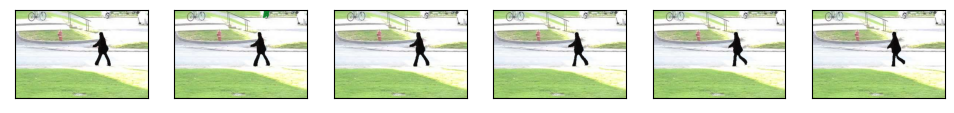

In [6]:
folder = 'pedestrians'
image_list = [read_image(f'baseline/{folder}/input/in000' + str(number) + '.jpg') for number in range(920,926)]

images = [transform(image).to(device) for image in image_list]
output = model(images)
output = filter_model_output(output, 0.8)
output = get_boolean_mask(output)
output = filter_output(output, ['person', 'bycicle'])
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])

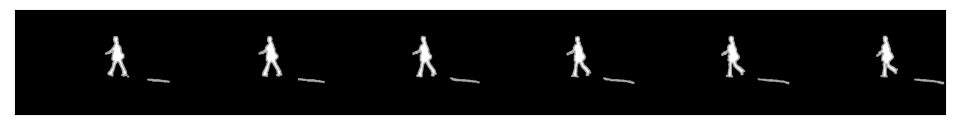

In [20]:
from torchvision.utils import make_grid

image_list = [read_image(f'baseline/{folder}/groundtruth/gt000' + str(number) + '.png') for number in range(920,926)]
grid = make_grid(image_list)
show(grid)


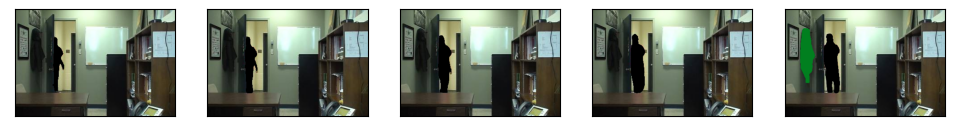

In [12]:
folder = 'office'
image_list = [read_image(f'baseline/{folder}/input/in000' + str(number) + '.jpg') for number in range(590,605,3)]

images = [transform(image).to(device) for image in image_list]
output = model(images)
output = filter_model_output(output, 0.8)
output = get_boolean_mask(output)
# output = filter_output_human(output)
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=1)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])

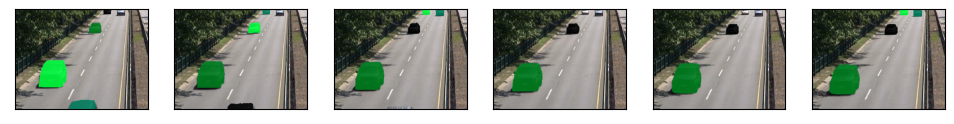

In [18]:
folder = 'highway'
image_list = [read_image(f'baseline/{folder}/input/in000' + str(number) + '.jpg') for number in range(920,926)]

images = [transform(image).to(device) for image in image_list]
output = model(images)
output = filter_model_output(output, 0.8)
output = get_boolean_mask(output)
# output = filter_output(output, ['car'])
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])

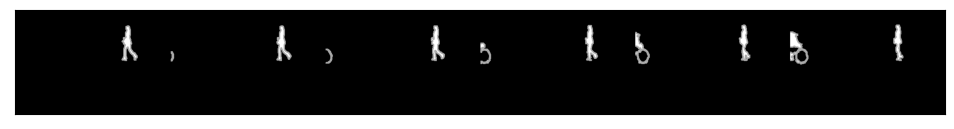

In [21]:
image_list = [read_image(f'baseline/pedestrians/groundtruth/gt000' + str(number) + '.png') for number in range(458,464)]
grid = make_grid(image_list)
show(grid)

Select 100 random images and test Ious

In [5]:
import random

def inference(score_threshold, class_name, images_number, folder_path):
    output_tensor_list = []
    #select the images containing the number
    images_path = [folder_path + f'/in{number}.jpg' for number in images_number]
    images = [read_image(image_path) for image_path in images_path]
    images = [transform(image) for image in images]
    images = [image.to(device) for image in images]
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        with torch.no_grad():
            outputs = model(batch)
        if class_name != None:
            outputs = filter_output(outputs, class_name)
        outputs = filter_model_output(outputs, score_threshold)
        for j,output in enumerate(outputs):
            try:
                mask = torch.max(output['masks'], axis=0).values.squeeze(0)
            except:
                mask = torch.zeros_like(images[j][0])
            output_tensor_list.append(mask)
    return output_tensor_list

def run_experiment(folder, class_names):
    ious = []
    score_threshold = [0.5, 0.5, 0.5, 0.1]
    folder_path_noblur = f"baseline\{folder}\input"
    # List all files in the folder
    files = os.listdir(folder_path_noblur)
    # Filter out non-image files (optional)
    image_files = [file for file in files if file.endswith((".jpg", ".jpeg", ".png"))]
    # Choose 100 images at random
    random_images = random.sample(image_files, 16)
    random_images_number = [extract_number(image) for image in random_images]
    for i,kernel in enumerate([0,5,15,35]):
        if i ==0:
            folder_path = folder_path_noblur
        else:
            folder_path = f"baseline\{folder}\input_blurred_{kernel}"
        
        output_tensor_list = inference(score_threshold[i], class_names, random_images_number, folder_path)
        ground_truth_paths = [f'baseline/{folder}/groundtruth/gt{number}.png' for number in random_images_number]
        ground_truth_images = [Image.open(ground_truth_path).convert('L') for ground_truth_path in ground_truth_paths]
        ground_truth_images_tensor = [F.to_tensor(ground_truth_image).to(device) for ground_truth_image in ground_truth_images]
        iou = 0
        for i in range(len(output_tensor_list)):
            iou += calculate_iou(ground_truth_images_tensor[i], output_tensor_list[i], 0.1)
        print(f'iou_folder_{folder}_kernel_{kernel}: {iou / len(output_tensor_list):.3f}')
        ious.append(iou / len(output_tensor_list))
    return ious        

# Blurred test

In [8]:
ious_highway=run_experiment('highway', ['car'])

iou_folder_highway_kernel_0: 0.713
iou_folder_highway_kernel_5: 0.545
iou_folder_highway_kernel_15: 0.207
iou_folder_highway_kernel_35: 0.026


In [7]:
ious = run_experiment('office', ['person'])

iou_folder_office_kernel_0: 0.666
iou_folder_office_kernel_5: 0.547
iou_folder_office_kernel_15: 0.688
iou_folder_office_kernel_35: 0.280


In [9]:
ious_pedestrians = run_experiment('pedestrians', ['person'])

iou_folder_pedestrians_kernel_0: 0.617
iou_folder_pedestrians_kernel_5: 0.678
iou_folder_pedestrians_kernel_15: 0.588
iou_folder_pedestrians_kernel_35: 0.179


In [10]:
ious_PETS2006 = run_experiment('PETS2006', ['person'])

iou_folder_PETS2006_kernel_0: 0.701
iou_folder_PETS2006_kernel_5: 0.686
iou_folder_PETS2006_kernel_15: 0.623
iou_folder_PETS2006_kernel_35: 0.536


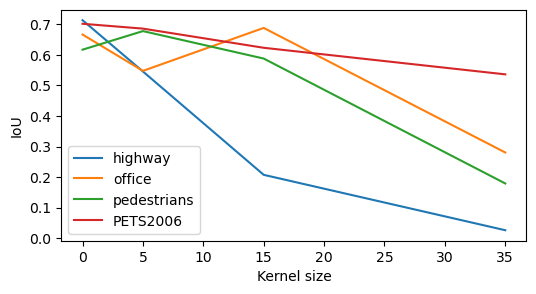

In [11]:

#plot all ious in 1 graph
plt.figure(figsize=(6,3))
plt.plot([0,5,15,35], ious_highway, label='highway')
plt.plot([0,5,15,35], ious, label='office')
plt.plot([0,5,15,35], ious_pedestrians, label='pedestrians')
plt.plot([0,5,15,35], ious_PETS2006, label='PETS2006')
plt.xlabel('Kernel size')
plt.ylabel('IoU')
plt.legend()
plt.show()

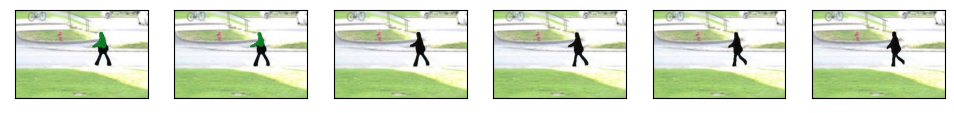

In [26]:
folder = 'pedestrians'
image_list = [read_image(f'baseline/{folder}/input_blurred_5/in000' + str(number) + '.jpg') for number in range(920,926)]

images = [transform(image).to(device) for image in image_list]
output = model(images)
output = filter_model_output(output, 0.8)
output = get_boolean_mask(output)
output = filter_output(output, ['person'])
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])

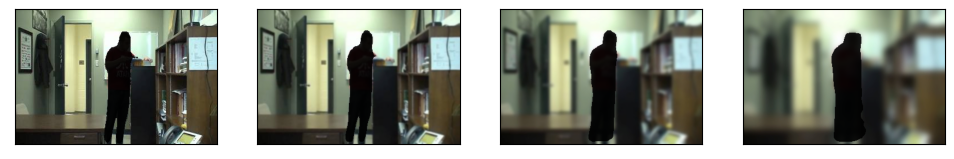

In [37]:
image_list = [read_image(f'baseline/office/input/in000920.jpg') ]
for blur in ['5','15','35']:
    image_list.append(read_image(f'baseline/office/input_blurred_{blur}/in000920.jpg'))

images = [transform(image).to(device) for image in image_list]
output = model(images)
output = filter_model_output(output, 0.5)
output = get_boolean_mask(output)
output = filter_output(output, ['person'])
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])

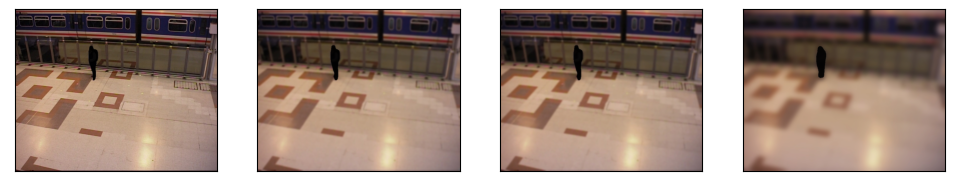

In [48]:
image_list = [read_image(f'baseline/PETS2006/input/in000305.jpg') ]
for blur in ['15','15','55']:
    image_list.append(read_image(f'baseline/PETS2006/input_blurred_{blur}/in000305.jpg'))

images = [transform(image).to(device) for image in image_list]
output = model(images)
output = filter_model_output(output, 0.5)
output = get_boolean_mask(output)
output = filter_output(output, ['person'])
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])

# Partially oberved test

In [15]:
number = {
    'highway': [i for i in range(600, 650)],
    'office': [i for i in range(582, 600)],
    'pedestrians': [i for i in range(460,465)],
    'PETS2006': [i for i in range(900, 930)]
}

In [16]:
for folder in ['highway', 'office', 'pedestrians', 'PETS2006']:
    pred_path = f'baseline/{folder}/prediction'
    prediction_selected = [f'mask0{number}.jpg' for number in number[folder]]
    ground_truth_selected = [f'gt000{number}.png' for number in number[folder]]
    #compute ious with the selected images
    iou=0
    for i in range(len(prediction_selected)):
        try:
            iou += calculate_iou(F.to_tensor(Image.open(f'{pred_path}/{prediction_selected[i]}')).to(device), F.to_tensor(Image.open(f'baseline/{folder}/groundtruth/{ground_truth_selected[i]}')).to(device))
        except:
            iou+=0
    print(f'iou_{folder}: {iou / len(prediction_selected):.3f}')

iou_highway: 0.769
iou_office: 0.544
iou_pedestrians: 0.584
iou_PETS2006: 0.825


c:\Users\Pierre\anaconda3\lib\site-packages\torchvision\utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


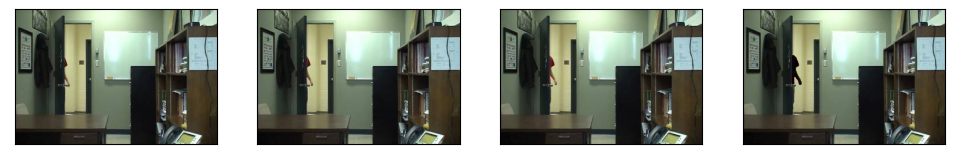

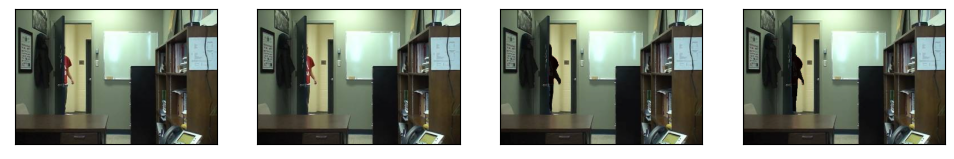

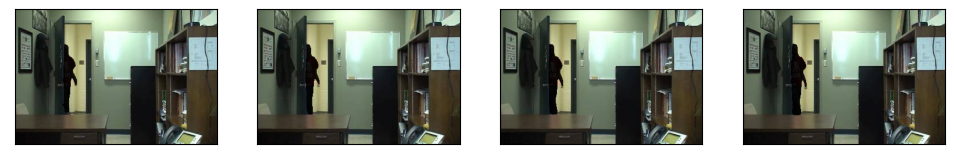

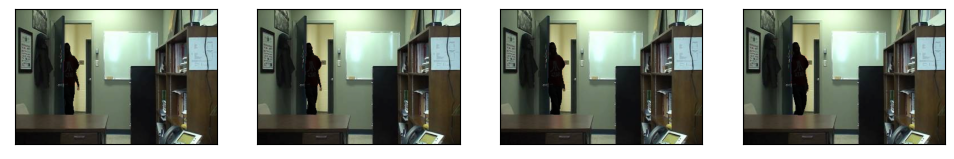

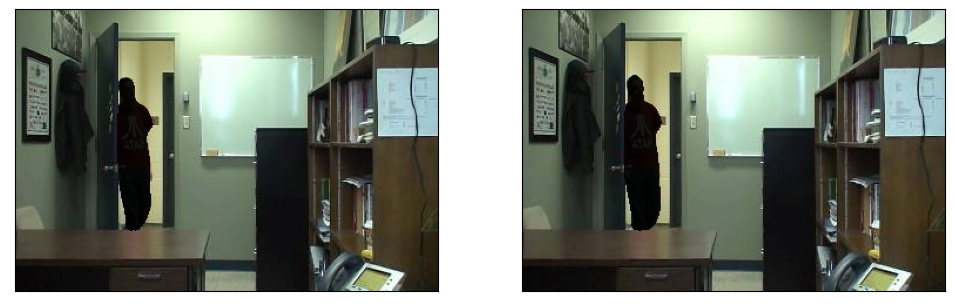

In [13]:
folder = 'office'
image_list = [read_image(f'baseline/{folder}/input/in000' + str(number) + '.jpg') for number in number[folder]]
images = [transform(image).to(device) for image in image_list]
#make batch prediction
for i in range(0, len(images), 4):
    image_list_batch = image_list[i:i+4]
    batch_images = images[i:i+4]
    with torch.no_grad():
        output = model(batch_images)
    output = filter_model_output(output, 0.95)
    output = get_boolean_mask(output)
    output = filter_output(output, ['person'])
    show([
        draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
        for index, (image, prediction) in enumerate(zip(image_list_batch, output))
    ])


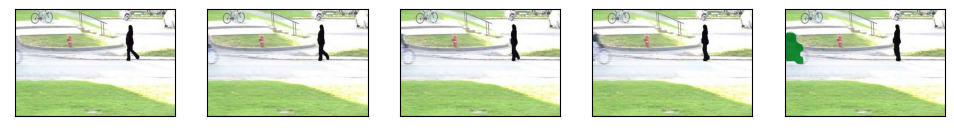

In [19]:
folder = 'pedestrians'
image_list = [read_image(f'baseline/{folder}/input/in000' + str(number) + '.jpg') for number in number[folder]]
images = [transform(image).to(device) for image in image_list]
#make batch prediction
for i in range(0, len(images), 5):
    image_list_batch = image_list[i:i+5]
    batch_images = images[i:i+5]
    with torch.no_grad():
        output = model(batch_images)
    output = filter_model_output(output, 0.8)
    output = get_boolean_mask(output)
    output = filter_output(output, ['person'])
    show([
        draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
        for index, (image, prediction) in enumerate(zip(image_list_batch, output))
    ])


# illumination test

In [33]:
import random

def inference(score_threshold, class_name, images_number, folder_path):
    output_tensor_list = []
    #select the images containing the number
    images_path = [folder_path + f'/in{number}.jpg' for number in images_number]
    images = [read_image(image_path) for image_path in images_path]
    images = [transform(image) for image in images]
    images = [image.to(device) for image in images]
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        with torch.no_grad():
            outputs = model(batch)
        # outputs = filter_model_output(outputs, score_threshold)
        if class_name != None:
            outputs = filter_output(outputs, class_name)
        outputs = filter_model_output(outputs, score_threshold)
        for j,output in enumerate(outputs):
            try:
                mask = torch.max(output['masks'], axis=0).values.squeeze(0)
            except:
                mask = torch.zeros_like(images[j][0])
            output_tensor_list.append(mask)
    return output_tensor_list

def run_experiment_illumination(folder, class_names):
    ious = []
    score_threshold = [0.5, 0.5, 0.5, 0.5,0.5]
    folder_path_noblur = f"baseline\{folder}\input"
    # List all files in the folder
    files = os.listdir(folder_path_noblur)
    # Filter out non-image files (optional)
    image_files = [file for file in files if file.endswith((".jpg", ".jpeg", ".png"))]
    # Choose 100 images at random
    random_images = random.sample(image_files, 16)
    random_images_number = [extract_number(image) for image in random_images]
    for i,factor in enumerate([0, 0.25, 0.5, 2, 4]):
        if i ==0:
            folder_path = folder_path_noblur
        else:
            folder_path = f"baseline\{folder}\input_light_{factor}"
        
        output_tensor_list = inference(score_threshold[i], class_names, random_images_number, folder_path)
        ground_truth_paths = [f'baseline/{folder}/groundtruth/gt{number}.png' for number in random_images_number]
        ground_truth_images = [Image.open(ground_truth_path).convert('L') for ground_truth_path in ground_truth_paths]
        ground_truth_images_tensor = [F.to_tensor(ground_truth_image).to(device) for ground_truth_image in ground_truth_images]
        iou = 0
        for i in range(len(output_tensor_list)):
            iou += calculate_iou(ground_truth_images_tensor[i], output_tensor_list[i], 0.1)
        print(f'iou_folder_{folder}_light_{factor}: {iou / len(output_tensor_list):.3f}')
        ious.append(iou / len(output_tensor_list))
    return ious     

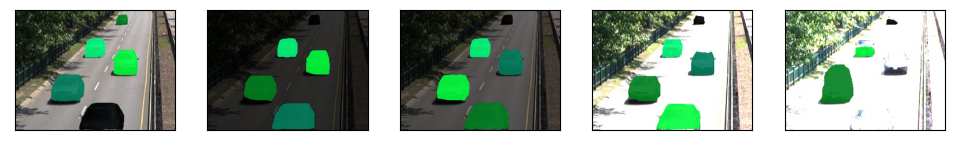

In [25]:
image_list = [read_image(f'baseline/highway/input/in000876.jpg') ]
for factor in ['0.25','0.5','2','4']:
    image_list.append(read_image(f'baseline/highway/input_light_{factor}/in000876.jpg'))

images = [transform(image).to(device) for image in image_list]
output = model(images)
output = filter_model_output(output, 0.5)
output = get_boolean_mask(output)
output = filter_output(output, ['car'])
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])

In [31]:
ious_highway = run_experiment_illumination('highway', ['car'])
ious_office = run_experiment_illumination('office', ['person'])

iou_folder_highway_light_0: 0.768
iou_folder_highway_light_0.25: 0.511
iou_folder_highway_light_0.5: 0.687
iou_folder_highway_light_2: 0.692
iou_folder_highway_light_4: 0.411
iou_folder_office_light_0: 0.666
iou_folder_office_light_0.25: 0.786
iou_folder_office_light_0.5: 0.705
iou_folder_office_light_2: 0.698
iou_folder_office_light_4: 0.802


In [34]:
ious_office = run_experiment_illumination('office', ['person'])

iou_folder_office_light_0: 0.806
iou_folder_office_light_0.25: 0.764
iou_folder_office_light_0.5: 0.671
iou_folder_office_light_2: 0.700
iou_folder_office_light_4: 0.786


In [36]:
ious_pedestrians = run_experiment_illumination('pedestrians', ['person'])

iou_folder_pedestrians_light_0: 0.582
iou_folder_pedestrians_light_0.25: 0.592
iou_folder_pedestrians_light_0.5: 0.591
iou_folder_pedestrians_light_2: 0.360
iou_folder_pedestrians_light_4: 0.009


In [30]:

ious_PETS2006 = run_experiment_illumination('PETS2006', ['person'])

iou_folder_PETS2006_light_0: 0.743
iou_folder_PETS2006_light_0.25: 0.734
iou_folder_PETS2006_light_0.5: 0.748
iou_folder_PETS2006_light_2: 0.489
iou_folder_PETS2006_light_4: 0.429


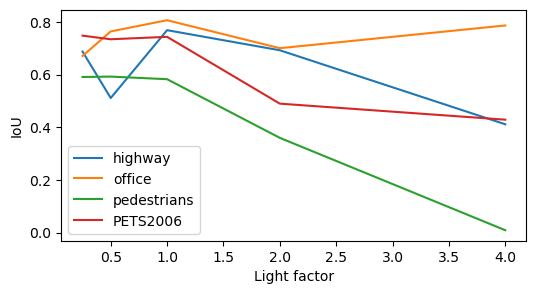

In [39]:
#exchange the first and 3rd element
ious_highway[0], ious_highway[2] = ious_highway[2], ious_highway[0]
ious_office[0], ious_office[2] = ious_office[2], ious_office[0]
ious_pedestrians[0], ious_pedestrians[2] = ious_pedestrians[2], ious_pedestrians[0]
ious_PETS2006[0], ious_PETS2006[2] = ious_PETS2006[2], ious_PETS2006[0]

#plot all ious in 1 graph
plt.figure(figsize=(6,3))
plt.plot([0.25,0.5,1,2,4], ious_highway, label='highway')
plt.plot([0.25,0.5,1,2,4], ious_office, label='office')
plt.plot([0.25,0.5,1,2,4], ious_pedestrians, label='pedestrians')
plt.plot([0.25,0.5,1,2,4], ious_PETS2006, label='PETS2006')
plt.xlabel('Light factor')
plt.ylabel('IoU')
plt.legend()
plt.show()
